<a href="https://colab.research.google.com/github/wesleydecezere/programa_ds_fc/blob/master/Entrega%206%20-%20S%C3%A9ries%20Temporais/Series_Temporais_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Séries temporais - Exercício</center>
___

Um dos grandes desafios das empresas é a previsão de vendas. Um bom modelo de previsão das vendas da empresa permite um melhor planejamento de gastos das empresas e da produção, permite uma estimação de lucros e até mesmo auxilia a empresa a determinar metas, avaliar o seu desempenho e ter uma melhor visão de futuro, ajudando na atração de possíveis investidores.

Esse notebook contém o exercício prático da aula de séries temporais. O *dataset* que utilizaremos e foi disponibilizado na pasta de dados da aula vem originalmente de um desafio de recrutamento do Walmart - que pode ser acessado [aqui](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data). Ele contém vendas anônimas por departamento para 45 lojas Walmart, bem como variáveis de apoio.

Assim, o exercício proposto aqui é de **prever as vendas semanais das lojas da Walmart**. Para isso, sugerimos você utilizar o modelo de machine learning *Random Forest* que vimos na aula, mas você pode também experimentar outros modelos que aprendemos.

Após todo o conhecimento que você adquiriu ao longo da trilha, você já está preparado para fazer um projeto sozinho. Assim, diferentemente dos outros exercícios, deixaremos o desafio para você estruturar o seu próprio código e modelo. Caso tenha dificuldade ou não saiba por onde começar, te recomendamos consultar os exemplos feitos ao longo das aulas para aplicar no exercício, e sinta-se livre para mandar suas dúvidas no grupo.

Bom, agora é com você!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importando as bibliotecas principais utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importando o dataset
walmart = pd.read_csv("/content/drive/MyDrive/Programa Ciência de Dados/Entrega 6 - Séries Temporais/data/walmart_sales.csv")

# Mostrando o formato e as primeiras linhas do dataset
print(walmart.shape)
walmart.head()

(282451, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,26,92,2011-08-26,87235.57,False,61.10,3.796,NaN,NaN,NaN,NaN,NaN,136.213613,7.767,A,152513
1,34,22,2011-03-25,5945.97,False,53.11,3.480,NaN,NaN,NaN,NaN,NaN,128.616064,10.398,A,158114
2,21,28,2010-12-03,1219.89,False,50.43,2.708,NaN,NaN,NaN,NaN,NaN,211.265543,8.163,B,140167
3,8,9,2010-09-17,11972.71,False,75.32,2.582,NaN,NaN,NaN,NaN,NaN,214.878556,6.315,A,155078
4,19,55,2012-05-18,8271.82,False,58.81,4.029,12613.98,NaN,11.5,1705.28,3600.79,138.106581,8.150,A,203819


#### Exploração dos dados

##### Departamentos por loja
* O número de departamentos é diferente de uma loja para outra: a maioria tem entre 70 e 80 departamentos, mas algumas tem em cerca de 60. 


In [4]:
walmart_store = np.sort(walmart.Store.unique())
walmart_store

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

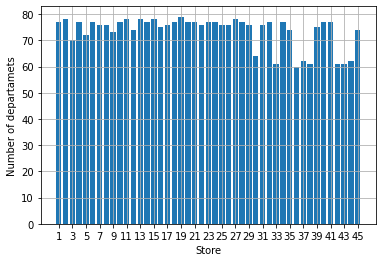

In [5]:
dept_qtd = list()

for idx, store in enumerate(walmart_store): 
   dept_qtd.append(walmart[walmart.Store == store].Dept.unique().size)

c = plt.bar(walmart_store, dept_qtd)
plt.ylabel('Number of departamets')
plt.xlabel('Store')
plt.xticks(range(1,46,2))
plt.grid(True)
plt.show()

##### Quantidade de amostras por departamento e loja
* Em uma mesma loja, os departamentos tem números de amostras bem diferentes: enquanto alguns departamentos tem mais de 100 amostras, outros tem apenas 3.
* Em um mesmo departamento de lojas diferentes, também não há uma regularidade no número de amostras: o departamento 96 da loja 1 tem cerca de 80, enquanto o mesmo departamento da loja 45 tem exatas 2 amostras. 

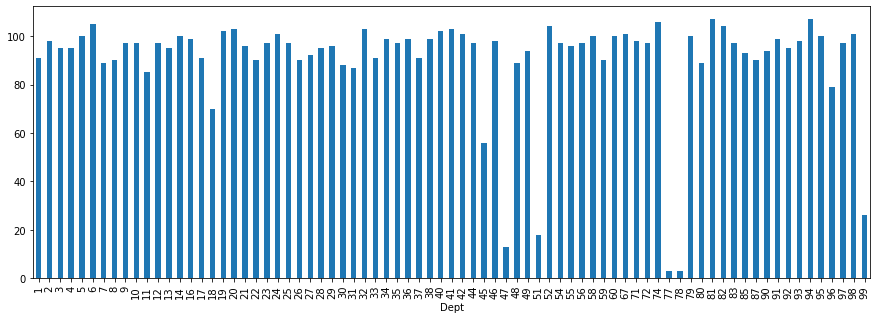

In [6]:
walmart[walmart.Store == 1].groupby('Dept')['Date'].count().plot.bar(figsize=(15,5))

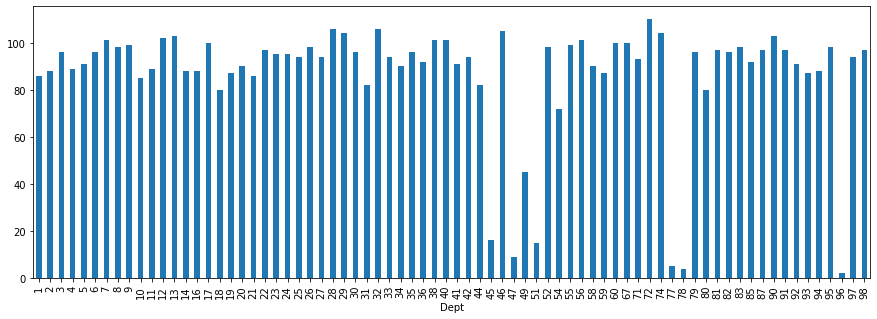

In [7]:
walmart[walmart.Store == 45].groupby('Dept')['Date'].count().plot.bar(figsize=(15,5))

##### Características iguais nos departamentos

Em uma mesma data, todos os departamentos de uma mesma loja apresentam as mesmas características (inclusive as de promoção, MarkDown1-5).


In [8]:
walmart_store1_2010_02_2016 = walmart[(walmart.Store == 1) & (walmart.Date == '2010-12-31')]
walmart_store1_2010_02_2016.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
4229,1,48,2010-12-31,434.00,True,48.43,2.943,NaN,NaN,NaN,NaN,NaN,211.404932,7.838,A,151315
6711,1,30,2010-12-31,2454.30,True,48.43,2.943,NaN,NaN,NaN,NaN,NaN,211.404932,7.838,A,151315
11898,1,40,2010-12-31,58568.16,True,48.43,2.943,NaN,NaN,NaN,NaN,NaN,211.404932,7.838,A,151315
20304,1,16,2010-12-31,4987.81,True,48.43,2.943,NaN,NaN,NaN,NaN,NaN,211.404932,7.838,A,151315
29355,1,79,2010-12-31,24738.86,True,48.43,2.943,NaN,NaN,NaN,NaN,NaN,211.404932,7.838,A,151315


In [9]:
walmart_store1_2010_02_2016.nunique()

Store            1
Dept            52
Date             1
Weekly_Sales    52
IsHoliday        1
Temperature      1
Fuel_Price       1
MarkDown1        0
MarkDown2        0
MarkDown3        0
MarkDown4        0
MarkDown5        0
CPI              1
Unemployment     1
Type             1
Size             1
dtype: int64

Portanto, dado uma data qualquer, nenhuma das características disponíveis influencia realmente o número de vendas semanais entre os departamentos de uma mesma loja. Nesta data, essas características podem influenciar somentes o volume de vendas entre lojas diferentes, mas não necessariamente. 

Isso me leva a crer que nenhuma das características é boa para auxiliar na previsão de vendas semanais entre os departamentos de uma mesma loja.

Algumas podem ser úteis, contudo, para avaliar as vendas entre departamentos de lojas diferentes.

#### Definição do problema/escopo: objetivo 

Como cada amostra do dataframe contém dados de um departamento de uma loja específica, o objetivo do modelo será **prever o número de vendas semanais, por departamento, de cada loja do Walmart**.


## Exercício 1: Pré-processamento de dados e criação de Features



#### Limpeza dos dados

In [10]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282451 entries, 0 to 282450
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         282451 non-null  int64  
 1   Dept          282451 non-null  int64  
 2   Date          282451 non-null  object 
 3   Weekly_Sales  282451 non-null  float64
 4   IsHoliday     282451 non-null  bool   
 5   Temperature   282451 non-null  float64
 6   Fuel_Price    282451 non-null  float64
 7   MarkDown1     100520 non-null  float64
 8   MarkDown2     74232 non-null   float64
 9   MarkDown3     91521 non-null   float64
 10  MarkDown4     90031 non-null   float64
 11  MarkDown5     101029 non-null  float64
 12  CPI           282451 non-null  float64
 13  Unemployment  282451 non-null  float64
 14  Type          282451 non-null  object 
 15  Size          282451 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 32.6+ MB


##### Tratamento de nulos

In [11]:
walmart_markdown = walmart.loc[:, 'MarkDown1':'MarkDown5']

print('Procentagem de nulos')

for markdown in walmart_markdown.columns:
  md = walmart_markdown[markdown]
  print(markdown, ':', md.isna().sum() / md.size * 100)

Procentagem de nulos
MarkDown1 : 64.41152624703047
MarkDown2 : 73.71862730172667
MarkDown3 : 67.59756559544842
MarkDown4 : 68.12509072370074
MarkDown5 : 64.2313179985201


Em todas as features de promoção, há mais de 60% de registros nulos. 

Conforme consta na descrição do dataset do Kaggle, os registros só estão disponíveis a partir de Nov 2011 e não não estão disponíveis para todas as lojas a todo momento.

Não cabe, portanto, substituir os NA por algum valor, pois estaríamos inserindo informações inadequadas no dataset. O mais sensato parece ser não trabalhar com estas features.

In [12]:
walmart.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       181931
MarkDown2       208219
MarkDown3       190930
MarkDown4       192420
MarkDown5       181422
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [13]:
walmart_treated = walmart.fillna(0)
walmart_treated.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

##### Conversões pertinentes (Data as datetime)


A variável `Date` é do tipo `object`. Portanto, cabe convertê-la para `datetime`

In [14]:
walmart_treated['Date'] = pd.to_datetime(walmart_treated.Date)

In [15]:
walmart_treated[['Date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282451 entries, 0 to 282450
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    282451 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.2 MB


##### Remoção de variáveis inúteis



##### Ordenação temporal das amostras (data como índice)

In [16]:
walmart_treated = walmart_treated.sort_values(by='Date')

### Criação de features



* Variável de informação temporal: as features de índice de preços ao consumidor (CPI, tipo IPCA), taxa de desemprego (Unployment) e preço da gasolina (Fuel_price) são variáveis fortemente dependentes do tempo; se elas realmente influenciam nas vendas semanais, o modelo deve ter uma noção clara de evolução temporal. 
* Variáveis Dummy para as features categóricas 

#### Informação temporal

Os registros vão de 05/fev/2010 até 01/nov/2012, com frequência semanal. Como uma datetime não diz muita coisa para o modelo, devemos converter a Date para algum formato útil.

In [17]:
walmart_treated.Date.dt.isocalendar()

,year,week,day
80235,2010,5,5
8583,2010,5,5
110078,2010,5,5
199024,2010,5,5
199085,2010,5,5
...,...,...,...
130856,2012,43,5
130877,2012,43,5
183165,2012,43,5
146438,2012,43,5


A contagem de vendas semanais é fechada sempre na sexta-feira (5º dia útil da semana). Portanto, o dia das datas não nos traz informação útil. Cabe manter no dataset somentre o ano e o mês de cada registro.

In [18]:
walmart_treated['week'] = walmart_treated.Date.dt.isocalendar().week
walmart_treated['year'] = walmart_treated.Date.dt.isocalendar().year

walmart_treated.drop('Date', axis=1, inplace=True)

In [19]:
walmart_treated.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,year
80235,20,44,10130.02,False,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187,A,203742,5,2010
8583,14,31,3798.40,False,27.31,2.784,0.0,0.0,0.0,0.0,0.0,181.871190,8.992,A,200898,5,2010


In [20]:
walmart_treated.tail(2)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,year
146438,7,9,21331.39,False,42.53,3.686,2818.42,24.03,2.97,343.26,1064.56,199.219532,7.557,B,70713,43,2012
63056,35,31,3621.67,False,58.99,3.882,6221.06,42.48,103.00,273.90,996.79,142.762411,8.665,B,103681,43,2012


#### Variáveis dummy

Como temos uma variável categórica multiclasse, a Type, devemos criar variáveis dummy para cada categoria, visando utilizá-las no Random Forest.

In [21]:
walmart_treated = pd.get_dummies(walmart_treated)
walmart_treated.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,week,year,Type_A,Type_B,Type_C
80235,20,44,10130.02,False,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187,203742,5,2010,1,0,0
8583,14,31,3798.40,False,27.31,2.784,0.0,0.0,0.0,0.0,0.0,181.871190,8.992,200898,5,2010,1,0,0


## Exercício 2: Separação dos conjuntos de treino e teste

* Split que não embaralhe os dados (`shuffle = False`)
* Expanding Windows para a validação cruzada (se não demorar uma eternidae, pois temos mais de 282 mil registros)

Primeiramente, temos que separar o target das features.

In [22]:
X = walmart_treated.drop('Weekly_Sales', axis=1)
y = walmart_treated['Weekly_Sales']

print(X.shape)
print(y.shape)

(282451, 18)
(282451,)


Na sequência, fazemos o split de treino e teste, sem embaralhar as amostras.

In [23]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split(X, y, 
                                                          test_size = 0.25, 
                                                          shuffle = False)

print("Train set X", X_training.shape)
print("Train set y", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Train set X (211838, 18)
Train set y (211838,)
Test set X (70613, 18)
Test set y (70613,)


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size = 0.33, 
                                                          shuffle = False)

print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Train set X (189242, 18)
Train set y (189242,)
Test set X (93209, 18)
Test set y (93209,)


Por fim, definimos uma Expanding Windows para utilização na validação cruzada.

In [25]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=10)

## Exercício 3: Construção do modelo e análise dos resultados

* Investigação manual de combinações de hiperparâmetros para obtenção de um noção das possíveis melhores combinações, visando diminuir o tempo de treino no GridSearch (se for rápido treinar)
* GridSearchCV para a obtenção definitiva dos melhores hiperparâmetros, juntamente com visualização das métricas nos conjuntos de treino e validação
* Avaliação das métricas MAE, MAPE e R2 nos conjuntos de training e teste


* Plot de comparação entre os valores reais e os valores previstos
* Plot de feature importance


In [26]:
# Importando as bibliotecas que vamos utilizar no modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

#### Hiperparâmetros padrão

Valor padrão dos hiperparâmetros selecionados
* `n_estimators`: 100
* `max_depth`: None
* `min_samples_split`: 2
* `min_samples_leaf`: 1 
* `max_features`: 'auto'

In [27]:
SEED = 42

# criando o objeto do modelo com RandomForestRegressor
rf_model_1 = RandomForestRegressor(random_state = SEED)

# treinando o modelo com os dados de treino
rf_model_1.fit(X_train, y_train)

# prevendo com o modelo nos dados de validação
y_pred = rf_model_1.predict(X_val)

Score on training set: 0.995
Score on validation set: 0.945
Explained variance score: 0.945
Mean absolute error (MAE): 2420.472
R² Score: 0.945


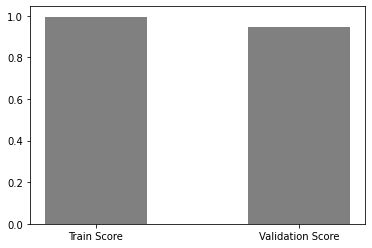

In [50]:
# calculando e imprimindo algumas métricas
print("Score on training set: {:.3f}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {:.3f}".format(rf_model_1.score(X_val, y_val)))
y = [rf_model_1.score(X_train, y_train), 
     rf_model_1.score(X_val, y_val)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="gray") 
print("Mean absolute error (MAE): {:.3f}".format(mean_absolute_error(y_val, y_pred)))
print("R² Score: {:.3f}".format(r2_score(y_val, y_pred)))

Como podemos ver, os resultados apresentados pelo modelo ficaram muito bons: um $R^2$ de 0.995 para os dados de treino e 0.945 para os de teste. Para o set de validação, obtivemos um MAE de 2420.472.

Podemos ter um certo overfit do dataset de treino. Por isso, faremos validação cruzada para avaliar o resultado.

#### Cross Validation: Expanding Windows

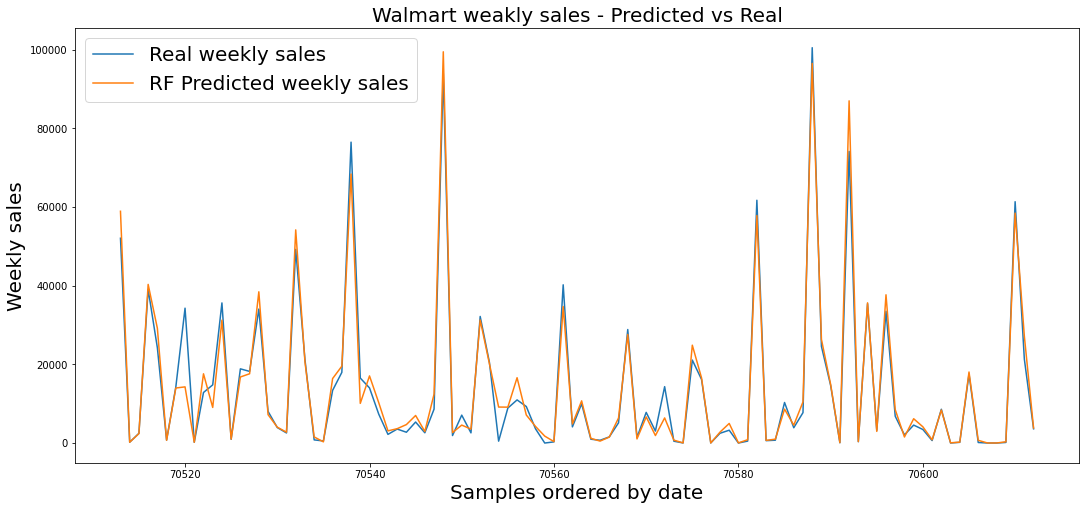

In [49]:
# Desenhando o gráfico de valores previstos por valores reais
plt.figure(figsize=(18,8))
plt.title('Walmart weakly sales - Predicted vs Real',fontsize=20)

df = pd.DataFrame({'real':y_val,'RF':y_pred})
df = df.reset_index(drop=True)


plt.plot(df.iloc[-100:])
plt.legend(['Real weekly sales','RF Predicted weekly sales'],fontsize=20)
plt.ylabel('Weekly sales',fontsize=20)
plt.xlabel('Samples ordered by date',fontsize=20)
plt.show()

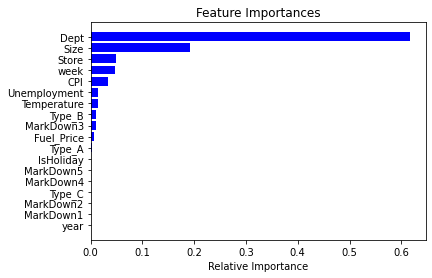

In [51]:
features = X.columns
importances = rf_model_1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### GridSearch

In [53]:
rf_model_1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Random Forest com Validação Cruzada e Grid Search para Séries temporais

# define os valores possíveis para os parâmetros a serem testados
params = {'n_estimators': [20, 100, 200, 500],
          'max_depth': [5, 10, 20, None],
          'max_features': [10, 14, 16, 18, 'auto'],
          'min_samples_split': [2, 3, 4, 5],
          'min_samples_leaf': [1, 2, 3, 4]
          }

# cria modelo
rf_model_cv_gs = RandomForestRegressor()

# objeto para grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, 
                           param_grid = params, 
                           return_train_score = True, 
                           cv = cv)

# treina modelo com Grid Search
grid_search.fit(X_training, y_training)

# imprime melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# resultados do cv
cv_results = pd.DataFrame(grid_search.cv_results_)

# print score médio nos sets de treino
print("Pontuação média nos dados de treino: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# print score médio nos sets de validação
print("Pontuação média nos dados de validação: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

y = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0], 
     cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
x = ["Train Score", "Test Score"]
width = 1/2
plt.bar(x, y, width, color="blue")  

# seta melhor opção baseada nos hiperparâmetros
# utiliza as melhores opções de hiperparâmetros encontrados
rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'])

# treina modelo com todos os dados de treino disponíveis e com os melhores hiperparâmetros encontrados
rf_model_cv_gs.fit(X_training, y_training)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

#### Resultados

In [29]:
# prevendo os valores no dataset de teste
y_pred_test = rf_model_1.predict(X_test)

In [30]:
print("Score on validation set: {:.3f}".format(rf_model_1.score(X_test, y_test)))
print("Mean absolute error (MAE): {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_test)))

Score on validation set: 0.946
Explained variance score: 0.946
Mean absolute error (MAE): 2361.305
Mean squared error (MSE): 26829432.404
R² Score: 0.946
